In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la simulación
num_particulas = 160
num_pasos = 100
dt = 1.0
num_simulaciones = 1
tamano_caja = 125.0
prob_izquierda = 2 / 3
num_obstaculos = 20  ### Nuevo: Número de obstáculos
tamano_obstaculos_max = np.sqrt(tamano_caja**2 / num_obstaculos)  ### Nuevo: Tamaño máximo permitido para los obstáculos



# Elasticidad del rebote (0 = totalmente inelástico, 1 = totalmente elástico)
elasticity = 0.9  ### Nuevo: Ajusta según la elasticidad deseada


In [15]:
# Crear una matriz para almacenar los MSD de cada simulación en la dirección x e y
msd_simulaciones = np.zeros((num_simulaciones, num_pasos + 1, 2))
distribucion_pasos = []
distribucion_angulos = []
trayectorias = []

In [16]:
for sim in range(num_simulaciones):
    posiciones = np.zeros((num_particulas, num_pasos + 1, 2))
    posiciones[:, 0] = np.random.uniform(-tamano_caja / 2, tamano_caja / 2, size=(num_particulas, 2))

    for i in range(num_pasos):
        random_steps = np.random.normal(0, np.sqrt(dt), size=(num_particulas, 2))
        angulos = np.random.choice([-180, 0], size=num_particulas, p=[prob_izquierda, 1-prob_izquierda])
        distribucion_angulos.append(angulos)
        direcciones = np.column_stack((np.cos(np.radians(angulos)), np.sin(np.radians(angulos))))
        posiciones[:, i+1] = posiciones[:, i] + random_steps * direcciones

        # Manejo de colisiones con las paredes de la caja
        posiciones[:, i+1] = np.maximum(np.minimum(posiciones[:, i+1], tamano_caja / 2), -tamano_caja / 2)

        # Manejo de colisiones con obstáculos
        for p in range(num_particulas):
            for o in range(num_obstaculos):
                distancia = np.linalg.norm(posiciones[p, i+1] - obstaculos_posiciones[o])
                if distancia < tamano_obstaculos_max / 2 + 0.5:  ### Nuevo: Considera el tamaño del obstáculo
                    direccion_choque = posiciones[p, i+1] - obstaculos_posiciones[o]
                    direccion_choque /= np.linalg.norm(direccion_choque)
                    posiciones[p, i+1] += 0.5 * direccion_choque * (1 + elasticity)
                    
    msd_simulaciones[sim, :, 0] = np.mean((posiciones[:, :, 0] - posiciones[:, 0, 0][:, np.newaxis])**2, axis=0)
    msd_simulaciones[sim, :, 1] = np.mean((posiciones[:, :, 1] - posiciones[:, 0, 1][:, np.newaxis])**2, axis=0)

    distribucion_pasos.append(np.sqrt(np.sum((posiciones[:, 1:] - posiciones[:, :-1])**2, axis=(1, 2))))
    trayectorias.append(posiciones)

In [17]:
msd_promedio = np.mean(msd_simulaciones, axis=0)
coeficiente_difusion_x = msd_promedio[:, 0] / (2 * np.arange(num_pasos + 1) * dt + 1e-10)
coeficiente_difusion_y = msd_promedio[:, 1] / (2 * np.arange(num_pasos + 1) * dt + 1e-10)

# Restablecer el tamaño de la figura
plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

Text(0, 0.5, 'Densidad')

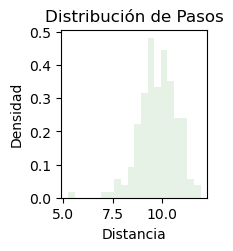

In [18]:
plt.subplot(231)
for distribucion_pasos in distribucion_pasos:
    plt.hist(distribucion_pasos, bins=20, density=True, alpha=0.1, color='g')
plt.title('Distribución de Pasos')
plt.xlabel('Distancia')
plt.ylabel('Densidad')

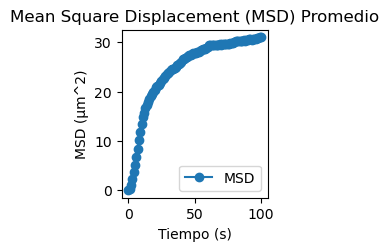

In [19]:
plt.subplot(232)
plt.plot(np.arange(num_pasos + 1) * dt, msd_promedio[:, 1], marker='o', linestyle='-', label='MSD')
plt.title('Mean Square Displacement (MSD) Promedio')
plt.xlabel('Tiempo (s)')
plt.ylabel('MSD (µm^2)')
plt.legend()

Text(0, 0.5, 'Densidad')

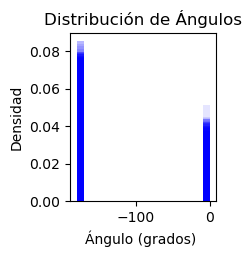

In [20]:
plt.subplot(235)
for distribucion_angulos in distribucion_angulos:
    plt.hist(distribucion_angulos, bins=20, density=True, alpha=0.1, color='b')
plt.title('Distribución de Ángulos')
plt.xlabel('Ángulo (grados) ')
plt.ylabel('Densidad')

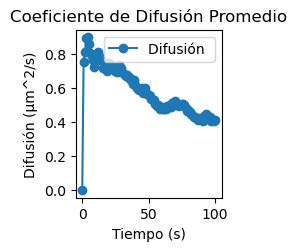

In [21]:
plt.subplot(233)
plt.plot(np.arange(num_pasos + 1) * dt, coeficiente_difusion_x, marker='o', linestyle='-', label='Difusión ')
plt.title('Coeficiente de Difusión Promedio')
plt.xlabel('Tiempo (s)')
plt.ylabel('Difusión (µm^2/s)')
plt.legend()

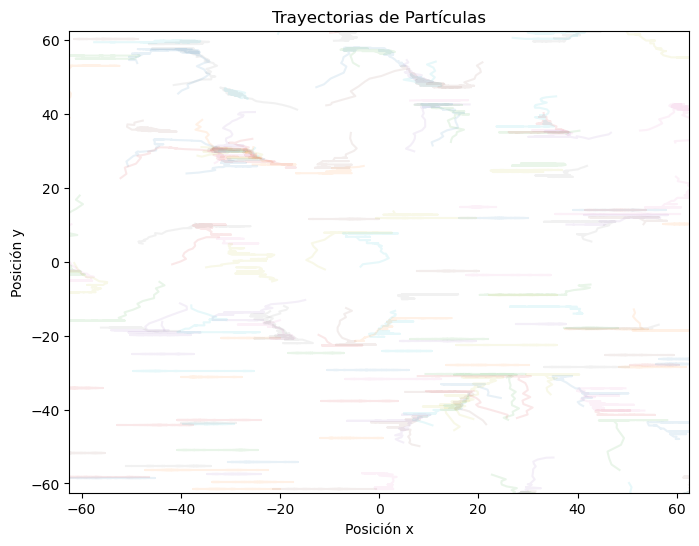

In [22]:
# Grafica trayectorias de partículas
plt.figure(figsize=(8, 6))
for trayectorias in trayectorias:
    for i in range(num_particulas):
        plt.plot(trayectorias[i, :, 0], trayectorias[i, :, 1], alpha=0.1)
plt.title('Trayectorias de Partículas')
plt.xlim(-tamano_caja / 2, tamano_caja / 2)
plt.ylim(-tamano_caja / 2, tamano_caja / 2)
plt.xlabel('Posición x')
plt.ylabel('Posición y')
plt.show()

In [23]:
# Crear un array para la autocorrelación de velocidades en la dirección x
autocorrelacion_velocidades_x = np.zeros(num_pasos - 1)  # Nota el ajuste del tamaño
autocorrelacion_velocidades_y = np.zeros(num_pasos - 1)

In [24]:
# Cálculo de velocidades en la dirección x
velocidades_x = np.diff(posiciones, axis=1) / dt
velocidades_y = np.diff(posiciones, axis=1) / dt

In [25]:
for tau in range(num_pasos - 1):
        # Calcula la suma de productos de velocidades con desplazamiento
        cv_x = np.mean(np.sum(velocidades_x[:, :num_pasos - tau] * velocidades_x[:, tau:], axis=1))
        autocorrelacion_velocidades_x[tau] = cv_x
        # Calcula la suma de productos de velocidades con desplazamiento en la dirección y
        cv_y = np.mean(np.sum(velocidades_y[:, :num_pasos - tau] * velocidades_y[:, tau:], axis=1))
        autocorrelacion_velocidades_y[tau] = cv_y

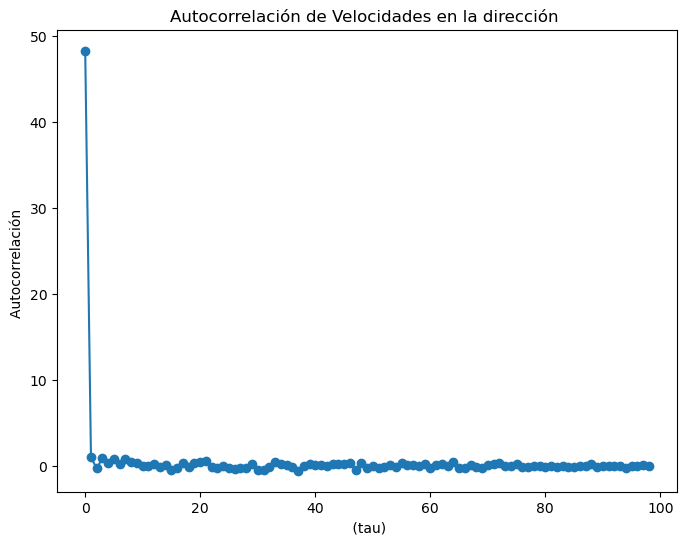

In [26]:
# Grafica la autocorrelación de velocidades en la dirección x
plt.figure(figsize=(8, 6))
plt.plot(np.arange(num_pasos - 1) * dt, autocorrelacion_velocidades_x, marker='o', linestyle='-')
plt.title('Autocorrelación de Velocidades en la dirección ')
plt.xlabel(' (tau)')
plt.ylabel('Autocorrelación ')
plt.show()